In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

            X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init
# from .cbam import *
# from .bam import *

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

In [7]:
model = ResidualNet("CIFAR10",depth=18, num_classes=7, att_type='cbam' )
model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [8]:
device = torch.device('cuda')
model = model.to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

In [9]:
model_path = './CBAM_rs18_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7688881158828735 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:39<00:00,  5.64it/s]

- Avg.loss: 1.866 | Avg.acc: 0.247



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.742 | Avg. val_acc: 0.278
* Update optimal model
Epoch:  2


Loss=1.7061480283737183 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.685 | Avg.acc: 0.320


- Avg. val_loss: 1.701 | Avg. val_acc: 0.357


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.3194118738174438 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.486 | Avg.acc: 0.420


- Avg. val_loss: 1.540 | Avg. val_acc: 0.447


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.1883597373962402 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.411 | Avg.acc: 0.454


- Avg. val_loss: 1.456 | Avg. val_acc: 0.452


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.0462396144866943 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.347 | Avg.acc: 0.477


- Avg. val_loss: 1.350 | Avg. val_acc: 0.488


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.6927093267440796 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.309 | Avg.acc: 0.496



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.363 | Avg. val_acc: 0.481
Epoch:  7


Loss=1.6754266023635864 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:40<00:00,  5.54it/s]

- Avg.loss: 1.282 | Avg.acc: 0.509


- Avg. val_loss: 1.228 | Avg. val_acc: 0.532


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.5402604341506958 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:40<00:00,  5.54it/s]

- Avg.loss: 1.260 | Avg.acc: 0.519


- Avg. val_loss: 1.212 | Avg. val_acc: 0.546


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.2866476774215698 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.235 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.529
Epoch:  10


Loss=1.3636038303375244 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.55it/s]

- Avg.loss: 1.217 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.541
Epoch:  11


Loss=1.4705833196640015 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:40<00:00,  5.54it/s]

- Avg.loss: 1.204 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.221 | Avg. val_acc: 0.534
Epoch:  12


Loss=1.0675770044326782 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 1.184 | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.249 | Avg. val_acc: 0.508
Epoch:  13


Loss=0.9688013195991516 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 1.173 | Avg.acc: 0.554


- Avg. val_loss: 1.188 | Avg. val_acc: 0.554


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.0750846862792969 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.160 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.541
Epoch:  15


Loss=1.2115108966827393 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.156 | Avg.acc: 0.559


- Avg. val_loss: 1.169 | Avg. val_acc: 0.564


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.0443617105484009 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.140 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.205 | Avg. val_acc: 0.528
Epoch:  17


Loss=1.3748197555541992 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.133 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.554
Epoch:  18


Loss=1.054794192314148 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 1.128 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.563
Epoch:  19


Loss=1.0718498229980469 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.118 | Avg.acc: 0.575


- Avg. val_loss: 1.129 | Avg. val_acc: 0.572


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.8976060152053833 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.115 | Avg.acc: 0.575


- Avg. val_loss: 1.111 | Avg. val_acc: 0.587


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.2782626152038574 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.105 | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.573
Epoch:  22


Loss=1.114180564880371 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.104 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.587
Epoch:  23


Loss=1.3141262531280518 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.093 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.191 | Avg. val_acc: 0.556
Epoch:  24


Loss=1.267531156539917 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.087 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.552
Epoch:  25


Loss=1.0488249063491821 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 1.085 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.563
Epoch:  26


Loss=1.2660566568374634 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.089 | Avg.acc: 0.584


- Avg. val_loss: 1.105 | Avg. val_acc: 0.591


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=1.0147100687026978 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.075 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153 | Avg. val_acc: 0.559
Epoch:  28


Loss=0.937412440776825 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.073 | Avg.acc: 0.590


- Avg. val_loss: 1.071 | Avg. val_acc: 0.604


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.2078860998153687 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 1.072 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.568
Epoch:  30


Loss=1.0010014772415161 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.074 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.104 | Avg. val_acc: 0.592
Epoch:  31


Loss=1.2539198398590088 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.063 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.589
Epoch:  32


Loss=1.2037177085876465 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.060 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.580
Epoch:  33


Loss=1.028478741645813 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.058 | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.577
Epoch:  34


Loss=1.188920259475708 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 1.056 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.586
Epoch:  35


Loss=1.1766796112060547 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.55it/s]

- Avg.loss: 1.058 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078 | Avg. val_acc: 0.596
Epoch:  36


Loss=0.9537717700004578 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 1.047 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.587
Epoch    36: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  37


Loss=0.7790204882621765 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 1.000 | Avg.acc: 0.621


- Avg. val_loss: 1.023 | Avg. val_acc: 0.618


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=1.0264947414398193 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.62it/s]

- Avg.loss: 0.989 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.610
Epoch:  39


Loss=0.9197245240211487 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.985 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.609
Epoch:  40


Loss=1.0001661777496338 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.980 | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024 | Avg. val_acc: 0.611
Epoch:  41


Loss=0.8089056611061096 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 0.975 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.609
Epoch:  42


Loss=1.278691053390503 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.972 | Avg.acc: 0.632


- Avg. val_loss: 1.013 | Avg. val_acc: 0.622


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  43


Loss=0.9634840488433838 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.964 | Avg.acc: 0.636



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026 | Avg. val_acc: 0.616
Epoch:  44


Loss=1.0401486158370972 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.960 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072 | Avg. val_acc: 0.596
Epoch:  45


Loss=1.0730953216552734 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.954 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.606
Epoch:  46


Loss=0.9893034100532532 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.958 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023 | Avg. val_acc: 0.616
Epoch:  47


Loss=1.2801907062530518 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.952 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.606
Epoch:  48


Loss=0.9097248911857605 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.949 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040 | Avg. val_acc: 0.609
Epoch:  49


Loss=0.8747451305389404 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.952 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054 | Avg. val_acc: 0.608
Epoch:  50


Loss=1.1449288129806519 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.56it/s]

- Avg.loss: 0.943 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.017 | Avg. val_acc: 0.617
Epoch    50: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  51


Loss=1.0137810707092285 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.914 | Avg.acc: 0.656


- Avg. val_loss: 1.000 | Avg. val_acc: 0.628


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  52


Loss=0.7355108261108398 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.899 | Avg.acc: 0.659


- Avg. val_loss: 0.989 | Avg. val_acc: 0.630


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  53


Loss=0.7054300308227539 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.894 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.626
Epoch:  54


Loss=0.7073939442634583 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.893 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.993 | Avg. val_acc: 0.626
Epoch:  55


Loss=0.9077636003494263 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:40<00:00,  5.60it/s]

- Avg.loss: 0.894 | Avg.acc: 0.663


- Avg. val_loss: 1.015 | Avg. val_acc: 0.631


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=1.0227599143981934 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.887 | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.623
Epoch:  57


Loss=0.7975577116012573 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]

- Avg.loss: 0.884 | Avg.acc: 0.669


- Avg. val_loss: 1.002 | Avg. val_acc: 0.638


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  58


Loss=0.7733729481697083 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.880 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.634
Epoch:  59


Loss=0.9572396278381348 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:40<00:00,  5.58it/s]

- Avg.loss: 0.876 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007 | Avg. val_acc: 0.628
Epoch:  60


Loss=1.1538469791412354 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:40<00:00,  5.57it/s]

- Avg.loss: 0.871 | Avg.acc: 0.673


- Avg. val_loss: 0.990 | Avg. val_acc: 0.643
Epoch    60: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  61


Loss=0.7480393052101135 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:40<00:00,  5.61it/s]

- Avg.loss: 0.847 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.985 | Avg. val_acc: 0.637
Epoch:  62


Loss=0.8948158025741577 Batch_id=9 Accuracy=0.6484375:   4%|▍         | 10/225 [00:06<02:12,  1.63it/s]


RuntimeError: DataLoader worker (pid 15442) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

In [11]:
for epoch in range(62, 100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  63


Loss=0.656764805316925 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:38<00:00,  5.82it/s]

- Avg.loss: 0.839 | Avg.acc: 0.684


- Avg. val_loss: 0.986 | Avg. val_acc: 0.644


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  64


Loss=0.8190911412239075 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:38<00:00,  5.80it/s]

- Avg.loss: 0.837 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.989 | Avg. val_acc: 0.637
Epoch:  65


Loss=0.9522705078125 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:38<00:00,  5.79it/s]

- Avg.loss: 0.833 | Avg.acc: 0.686



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.992 | Avg. val_acc: 0.641
Epoch:  66


Loss=1.1351505517959595 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:38<00:00,  5.77it/s]

- Avg.loss: 0.830 | Avg.acc: 0.687



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.982 | Avg. val_acc: 0.643
Epoch:  67


Loss=0.8991237282752991 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:39<00:00,  5.77it/s]

- Avg.loss: 0.825 | Avg.acc: 0.689


- Avg. val_loss: 0.986 | Avg. val_acc: 0.645


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  68


Loss=0.9334753155708313 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

- Avg.loss: 0.828 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.638
Epoch:  69


Loss=0.9783560037612915 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:38<00:00,  5.79it/s]

- Avg.loss: 0.820 | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.640
Epoch:  70


Loss=0.7655182480812073 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.75it/s]

- Avg.loss: 0.816 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.999 | Avg. val_acc: 0.639
Epoch:  71


Loss=0.9612401723861694 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.73it/s]

- Avg.loss: 0.816 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.644
Epoch:  72


Loss=0.6316048502922058 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:39<00:00,  5.72it/s]

- Avg.loss: 0.818 | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.633
Epoch:  73


Loss=0.987769365310669 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:39<00:00,  5.68it/s]

- Avg.loss: 0.811 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.640
Epoch:  74


Loss=0.9964476823806763 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:39<00:00,  5.73it/s]

- Avg.loss: 0.808 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.635
Epoch    73: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  75


Loss=0.7894533276557922 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:39<00:00,  5.68it/s]

- Avg.loss: 0.799 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.641
Epoch:  76


Loss=0.8184816837310791 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:39<00:00,  5.71it/s]

- Avg.loss: 0.791 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.644
Epoch:  77


Loss=1.0512020587921143 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:39<00:00,  5.67it/s]

- Avg.loss: 0.787 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.635
Epoch:  78


Loss=0.928924024105072 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.70it/s]

- Avg.loss: 0.787 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.638
Epoch:  79


Loss=0.947776198387146 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:39<00:00,  5.75it/s]

- Avg.loss: 0.782 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.643
Epoch:  80


Loss=1.0177217721939087 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:39<00:00,  5.71it/s]

- Avg.loss: 0.785 | Avg.acc: 0.705



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.994 | Avg. val_acc: 0.640
Epoch:  81


Loss=0.5859946012496948 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:39<00:00,  5.73it/s]

- Avg.loss: 0.781 | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006 | Avg. val_acc: 0.639
Epoch:  82


Loss=0.5706934332847595 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:39<00:00,  5.73it/s]

- Avg.loss: 0.777 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.644
Epoch    81: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  83


Loss=0.7620978951454163 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:39<00:00,  5.71it/s]

- Avg.loss: 0.770 | Avg.acc: 0.711



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.643
Epoch:  84


Loss=0.6560284495353699 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:38<00:00,  5.78it/s]

- Avg.loss: 0.768 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.642
Epoch:  85


Loss=0.690865159034729 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:39<00:00,  5.72it/s]

- Avg.loss: 0.766 | Avg.acc: 0.714



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.644
Epoch:  86


Loss=0.6223787069320679 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:39<00:00,  5.72it/s]

- Avg.loss: 0.766 | Avg.acc: 0.711


- Avg. val_loss: 0.994 | Avg. val_acc: 0.646


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  87


Loss=0.7528093457221985 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

- Avg.loss: 0.765 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.645
Epoch:  88


Loss=0.8350701928138733 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:38<00:00,  5.79it/s]

- Avg.loss: 0.766 | Avg.acc: 0.712



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.642
Epoch:  89


Loss=0.9487649202346802 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

- Avg.loss: 0.761 | Avg.acc: 0.713


- Avg. val_loss: 0.999 | Avg. val_acc: 0.648


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  90


Loss=0.6880560517311096 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:39<00:00,  5.75it/s]

- Avg.loss: 0.758 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.998 | Avg. val_acc: 0.644
Epoch    89: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  91


Loss=0.8355632424354553 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

- Avg.loss: 0.753 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.000 | Avg. val_acc: 0.641
Epoch:  92


Loss=0.9937259554862976 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.73it/s]

- Avg.loss: 0.753 | Avg.acc: 0.717



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.996 | Avg. val_acc: 0.643
Epoch:  93


Loss=0.7018499374389648 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:39<00:00,  5.75it/s]

- Avg.loss: 0.749 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.001 | Avg. val_acc: 0.646
Epoch:  94


Loss=0.6916701197624207 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:39<00:00,  5.73it/s]

- Avg.loss: 0.750 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.003 | Avg. val_acc: 0.643
Epoch:  95


Loss=0.8395495414733887 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:39<00:00,  5.76it/s]

- Avg.loss: 0.750 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.646
Epoch:  96


Loss=0.6089591979980469 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

- Avg.loss: 0.753 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.997 | Avg. val_acc: 0.646
Epoch:  97


Loss=0.8999311327934265 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.77it/s]

- Avg.loss: 0.742 | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.646
Epoch:  98


Loss=0.9048716425895691 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

- Avg.loss: 0.750 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.645
Epoch    97: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  99


Loss=0.9093842506408691 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:39<00:00,  5.75it/s]

- Avg.loss: 0.750 | Avg.acc: 0.718



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.002 | Avg. val_acc: 0.646
Epoch:  100


Loss=0.7644092440605164 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:39<00:00,  5.72it/s]

- Avg.loss: 0.749 | Avg.acc: 0.719


- Avg. val_loss: 1.001 | Avg. val_acc: 0.645
Finished Training


([<matplotlib.lines.Line2D at 0x7f3c72b92e10>,
 0.6480913903594316)

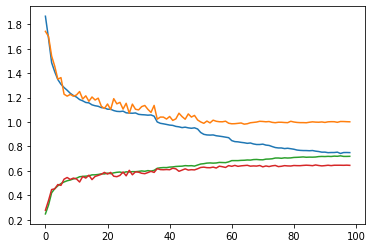

In [12]:
import pickle
pickle.dump(hist, open('CBAM_rs18_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [13]:
model = torch.load('CBAM_rs18_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.961 | Avg. val_acc: 0.660
